<a href="https://colab.research.google.com/github/uGAliok/jupyter_notebooks/blob/main/%D0%93%D0%B0%D0%B3%D0%B0%D1%80%D0%B8%D0%BD%D0%B0_%D1%81%D1%82%D0%B0%D1%82_%D1%82%D0%B5%D1%81%D1%82%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Параметрические и непараметрические тесты для сравнения выборок Social Media Users

Я взяла на платформе Kaggle датасет Social Media Users.

Изучим датасет:

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu, f_oneway, fisher_exact
from google.colab import drive
import kagglehub
import os
import shutil

path = kagglehub.dataset_download("refiaozturk/online-shopping-dataset")
print("Path to dataset files:", path)

folder = "./datasets"
os.makedirs(folder, exist_ok=True)
for file_name in os.listdir(path):
  full_file_path = os.path.join(path, file_name)
  shutil.copy(full_file_path, folder)
data_file = os.path.join(folder, "dataset.csv")

df = pd.read_csv(data_file)
df.head()

100%|██████████| 177k/177k [00:00<00:00, 48.2MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/refiaozturk/online-shopping-dataset/versions/1


,User ID,Age,Gender,Country,Purchase Amount,Purchase Date,Product Category
0,1,56.0,Female,USA,331.79,2021-11-21,Sports
1,2,69.0,Male,Australia,335.72,2022-03-05,Home & Kitchen
2,3,46.0,NaN,Germany,493.18,NaN,Books
3,4,32.0,Male,Germany,80.97,2023-06-08,Sports
4,5,60.0,Female,UK,21.75,NaN,Beauty


Изучим датасет:

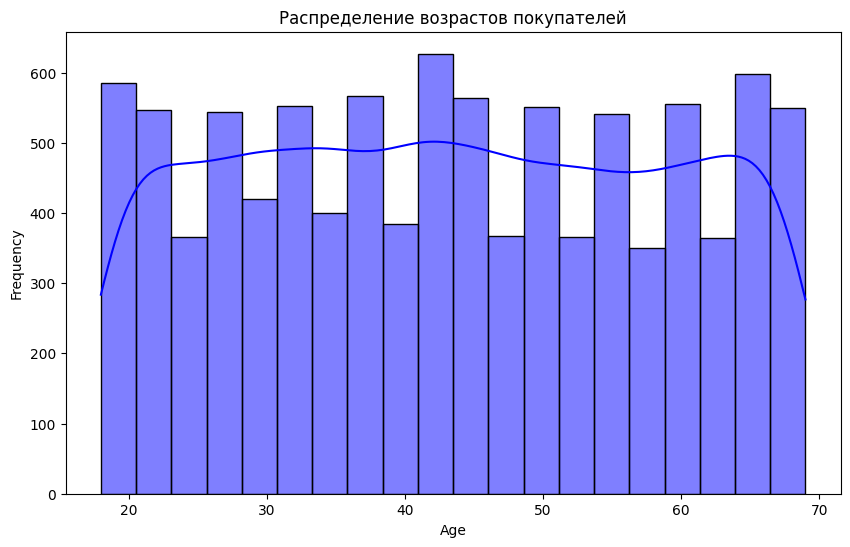

<ipython-input-3-83d86781954f>:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='Age Group', y='Purchase Amount', ci=None, palette='viridis')
<ipython-input-3-83d86781954f>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Age Group', y='Purchase Amount', ci=None, palette='viridis')


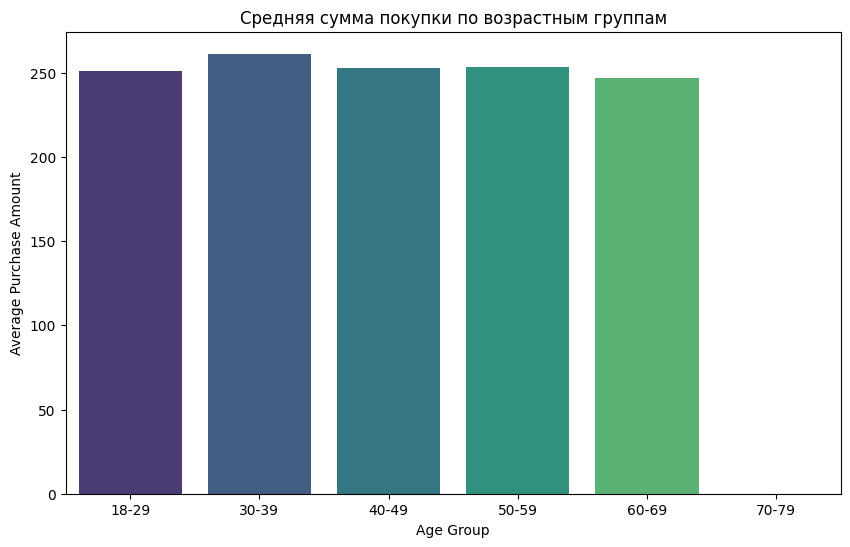

<ipython-input-3-83d86781954f>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='Product Category', order=df['Product Category'].value_counts().index, palette='viridis')


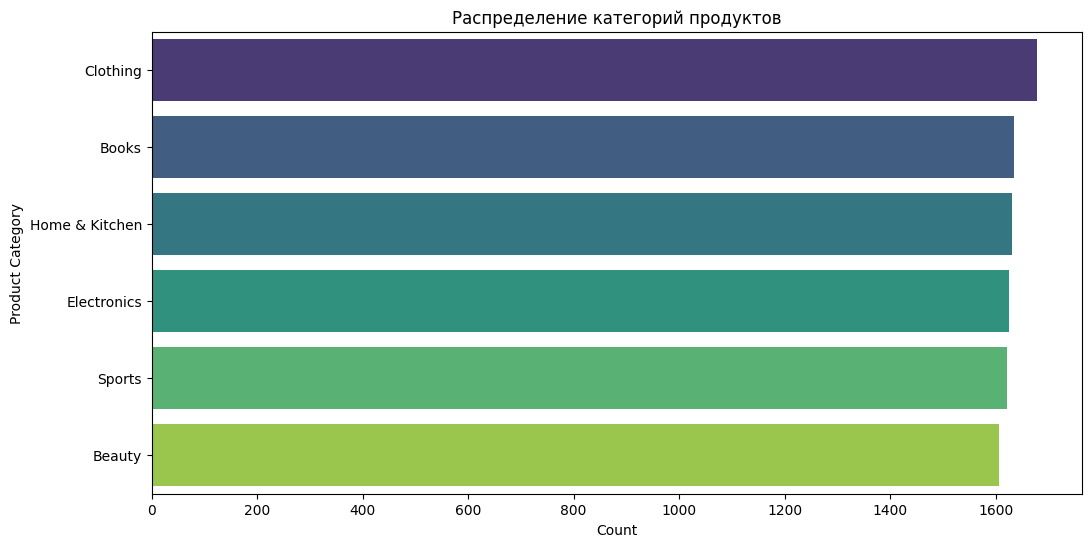

<ipython-input-3-83d86781954f>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Gender', y='Purchase Amount', palette='viridis')


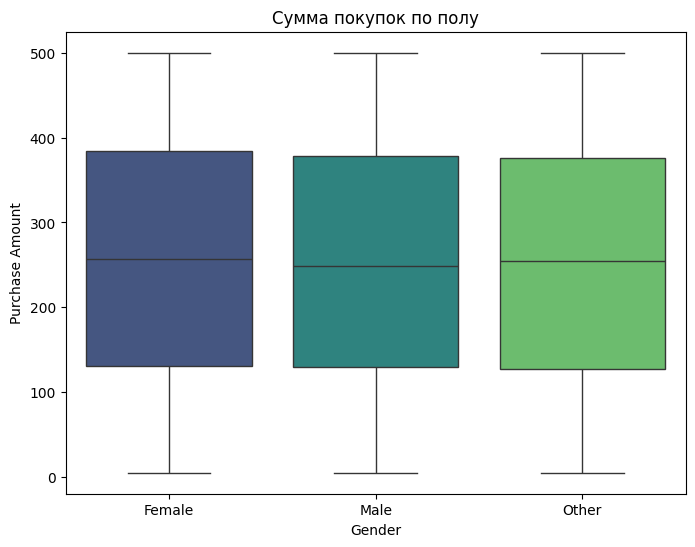

<ipython-input-3-83d86781954f>:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette='viridis')


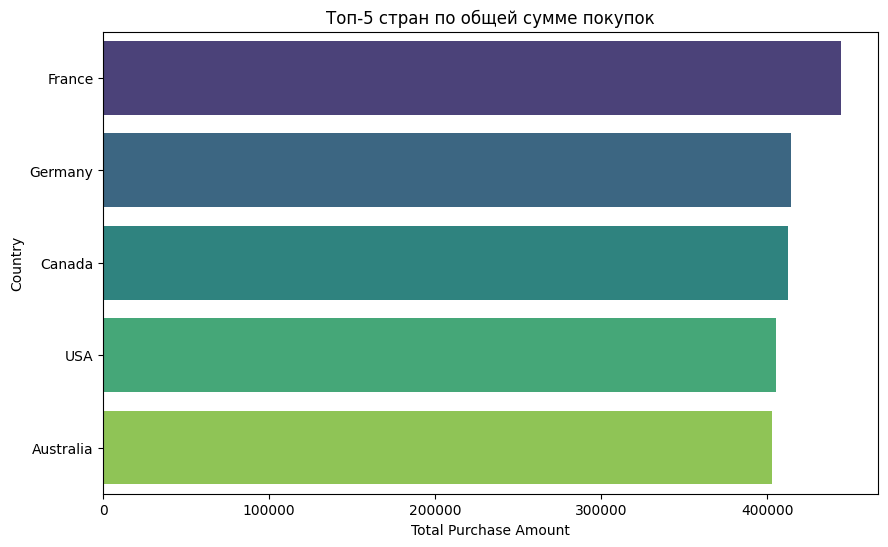

In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

df = df.dropna(subset=['Age', 'Gender', 'Country', 'Purchase Amount', 'Product Category'])

# 1
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], kde=True, bins=20, color='blue')
plt.title('Распределение возрастов покупателей')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# 2
age_bins = [18, 30, 40, 50, 60, 70, 80]
age_labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70-79']
df['Age Group'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Age Group', y='Purchase Amount', ci=None, palette='viridis')
plt.title('Средняя сумма покупки по возрастным группам')
plt.xlabel('Age Group')
plt.ylabel('Average Purchase Amount')
plt.show()

# 3
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='Product Category', order=df['Product Category'].value_counts().index, palette='viridis')
plt.title('Распределение категорий продуктов')
plt.xlabel('Count')
plt.ylabel('Product Category')
plt.show()

# 4
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Gender', y='Purchase Amount', palette='viridis')
plt.title('Сумма покупок по полу')
plt.xlabel('Gender')
plt.ylabel('Purchase Amount')
plt.show()

# 5
top_countries = df.groupby('Country')['Purchase Amount'].sum().sort_values(ascending=False).head(5)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_countries.values, y=top_countries.index, palette='viridis')
plt.title('Топ-5 стран по общей сумме покупок')
plt.xlabel('Total Purchase Amount')
plt.ylabel('Country')
plt.show()


Разобьем на сегменты нашу аудиторию и применим для нескольких (примерно 3-4 метрики) метрик тесты Стьюдента, Манна-Уитни, Фишера (Фишера для нескольких сегментов).

Создадим четыре сегмента: выборки для мужчин и женщин, выборки для возрастных групп (18-29, 30-39), исследуем на нормальность их выборочные средние и применим тесты


In [ ]:
from scipy.stats import ttest_ind, mannwhitneyu, shapiro
import numpy as np

def check_sample_means_normality(data, n_resamples=1000):
    means = []
    for _ in range(n_resamples):
        sample = np.random.choice(data, size=100, replace=True)
        means.append(np.mean(sample))
    return shapiro(means)

# --- сегменты ---
purchase_male = df[df['Gender'] == 'Male']['Purchase Amount'].dropna()
purchase_female = df[df['Gender'] == 'Female']['Purchase Amount'].dropna()

age_18_29 = df[df['Age Group'] == '18-29']['Purchase Amount'].dropna()
age_30_39 = df[df['Age Group'] == '30-39']['Purchase Amount'].dropna()

# --- Тест Манна-Уитни ---
# 1
u_stat, u_p_value = mannwhitneyu(purchase_male, purchase_female, alternative='two-sided')
print("Манна-Уитни (мужчины vs женщины):", u_stat, u_p_value)

# 3
u_stat, u_p_value = mannwhitneyu(age_18_29, age_30_39, alternative='two-sided')
print("Манна-Уитни (18-29 vs 30-39):", u_stat, u_p_value)

# --- Проверка нормальности выборочных средних ---
# 1.
shapiro_male = check_sample_means_normality(purchase_male)
print("Нормальность выборочных средних (мужчины):", shapiro_male)

shapiro_female = check_sample_means_normality(purchase_female)
print("Нормальность выборочных средних (женщины):", shapiro_female)

# 2
shapiro_18_29 = check_sample_means_normality(age_18_29)
print("Нормальность выборочных средних (18-29):", shapiro_18_29)

shapiro_30_39 = check_sample_means_normality(age_30_39)
print("Нормальность выборочных средних (30-39):", shapiro_30_39)

# --- Тест Стьюдента ---
# 1
if shapiro_male.pvalue > 0.05 and shapiro_female.pvalue > 0.05:
    t_stat, t_p_value = ttest_ind(purchase_male, purchase_female, equal_var=True)
    print('T-test (мужчины vs женщины):', t_stat, t_p_value)

# 2
if shapiro_18_29.pvalue > 0.05 and shapiro_30_39.pvalue > 0.05:
    t_stat, t_p_value = ttest_ind(age_18_29, age_30_39, equal_var=True)
    print('T-test (18-29 vs 30-39):', t_stat, t_p_value)

Манна-Уитни (мужчины vs женщины): 5260555.5 0.17126048920286074
Манна-Уитни (18-29 vs 30-39): 2058687.0 0.01942000524680582
Нормальность выборочных средних (мужчины): ShapiroResult(statistic=0.9983079305022843, pvalue=0.4360491021113957)
Нормальность выборочных средних (женщины): ShapiroResult(statistic=0.9984008107646265, pvalue=0.4915485148237913)
Нормальность выборочных средних (18-29): ShapiroResult(statistic=0.997992030240783, pvalue=0.27931188675652774)
Нормальность выборочных средних (30-39): ShapiroResult(statistic=0.9983700960821822, pvalue=0.47277403858472067)
T-test (мужчины vs женщины): -1.3700125862178065 0.17072993034321032
T-test (18-29 vs 30-39): -2.323586455375012 0.02019564708485622


В данном случае можем применять оба теста и для обеих выборок результаты тестов согласуюься:
* p-value(муж/жен) > 0,05 => средние суммы покупок у мужчин и женщин схожи и их медианы не отличаются статистически значимо
* p-value(18-29/30-39) < 0,05 => отвергаем гипотезу о о том что суммы покупок этих групп не отличаются статистически значимо.


Тпереь применим тест Фишера для нескольких сегментов:

In [ ]:
from scipy.stats import f_oneway

age_18_29 = df[df['Age Group'] == '18-29']['Purchase Amount'].dropna()
age_30_39 = df[df['Age Group'] == '30-39']['Purchase Amount'].dropna()
age_40_49 = df[df['Age Group'] == '40-49']['Purchase Amount'].dropna()
age_50_59 = df[df['Age Group'] == '50-59']['Purchase Amount'].dropna()
age_60_69 = df[df['Age Group'] == '60-69']['Purchase Amount'].dropna()

top_categories = df['Product Category'].value_counts().head(5).index
category_groups = [df[df['Product Category'] == cat]['Purchase Amount'].dropna() for cat in top_categories]

top_countries = df['Country'].value_counts().head(5).index
country_groups = [df[df['Country'] == country]['Purchase Amount'].dropna() for country in top_countries]

# --- Тест Фишера ---
# 1
f_stat_age, p_value_age = f_oneway(age_18_29, age_30_39, age_40_49, age_60_69)
print('F-test для возрастных групп (18-29, 30-39, 40-49б 60-69):', f_stat_age, p_value_age)

# 2
f_stat_category, p_value_category = f_oneway(*category_groups)
print('F-test для категорий продуктов (топ-5):', f_stat_category, p_value_category)

# 3
f_stat_country, p_value_country = f_oneway(*country_groups)
print('F-test для стран (топ-5):', f_stat_country, p_value_country)


F-test для возрастных групп (18-29, 30-39, 40-49б 60-69): 3.4075072182341133 0.01681177800614674
F-test для категорий продуктов (топ-5): 0.38652363518681754 0.8184385815694368
F-test для стран (топ-5): 0.10922176602027225 0.9793433279281579


1: p-value < 0,05 => можно отвергнуть нулевую гипотезу и сделать вывод о наличии статистически значимых различий между группами

2 и 3: p-value > 0,05 => средние значения в этих группах равны

Теперь проведем попарные сравнения:

In [ ]:
from itertools import combinations

age_groups = [age_18_29, age_30_39, age_40_49, age_50_59, age_60_69]
age_group_labels = ['18-29', '30-39', '40-49', '50-59', '60-69']

# --- Тест Фишера ---
pair_results_fisher = []
for (group1, label1), (group2, label2) in combinations(zip(age_groups, age_group_labels), 2):
    f_stat_pair, f_p_value_pair = f_oneway(group1, group2)
    pair_results_fisher.append({
        'Группа 1': label1,
        'Группа 2': label2,
        'статистика': f_stat_pair,
        'p-value': f_p_value_pair
    })
pairwise_fisher_results = pd.DataFrame(pair_results_fisher)
print("\nЧерез тест Фишера (F-test):")
print(pairwise_fisher_results)

# --- Тест Стьюдента ---
pair_results = []
for (group1, label1), (group2, label2) in combinations(zip(age_groups, age_group_labels), 2):
    t_stat, t_p_value = ttest_ind(group1, group2, equal_var=True)
    pair_results.append({
        'Группа 1': label1,
        'Группа 2': label2,
        'статистика': t_stat,
        'p-value': t_p_value
    })
pairwise_results = pd.DataFrame(pair_results)
print("\nЧерез тест Стьюдента (T-test):")
print(pairwise_results)

print(f"\nПри этом общий тест Фишера показывает p-value = {p_value_age}")


Через тест Фишера (F-test):
  Группа 1 Группа 2  статистика   p-value
0    18-29    30-39    5.399054  0.020196
1    18-29    40-49    0.166258  0.683480
2    18-29    50-59    0.299339  0.584327
3    18-29    60-69    0.766709  0.381288
4    30-39    40-49    3.442255  0.063625
5    30-39    50-59    2.830697  0.092562
6    30-39    60-69    9.485908  0.002085
7    40-49    50-59    0.020202  0.886982
8    40-49    60-69    1.538646  0.214896
9    50-59    60-69    1.853375  0.173474

Через тест Стьюдента (T-test):
  Группа 1 Группа 2  статистика   p-value
0    18-29    30-39   -2.323586  0.020196
1    18-29    40-49   -0.407747  0.683480
2    18-29    50-59   -0.547118  0.584327
3    18-29    60-69    0.875619  0.381288
4    30-39    40-49    1.855331  0.063625
5    30-39    50-59    1.682468  0.092562
6    30-39    60-69    3.079920  0.002085
7    40-49    50-59   -0.142134  0.886982
8    40-49    60-69    1.240422  0.214896
9    50-59    60-69    1.361387  0.173474

При этом общий

Общий тест Фишера показывает наличие различий между группами, что соответствует попарным тестам, видно, что между некоторыми парами групп есть статистически значимые различия.

In [ ]:
def bootstrap_ci(data, stat_func=np.mean, n_bootstrap=1000):
    bootstrap_stats = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_stats.append(stat_func(sample))
    bootstrap_stats = np.array(bootstrap_stats)

    lower_quantile = 0.025
    upper_quantile = 0.975
    exact_ci = np.percentile(bootstrap_stats, [lower_quantile * 100, upper_quantile * 100])

    mean_stat = stat_func(data)
    bias = mean_stat - np.mean(bootstrap_stats)
    corrected_stats = 2 * mean_stat - bootstrap_stats
    efron_ci = np.percentile(corrected_stats, [lower_quantile * 100, upper_quantile * 100])
    return exact_ci, efron_ci


purchase_male = df[df['Gender'] == 'Male']['Purchase Amount'].dropna()
exact_ci, efron_ci = bootstrap_ci(purchase_male, stat_func=np.mean, n_bootstrap=10000)

purchase_female = df[df['Gender'] == 'Female']['Purchase Amount'].dropna()
exact_ci_female, efron_ci_female = bootstrap_ci(purchase_female, stat_func=np.mean, n_bootstrap=10000)

age_groups_intervals = {}
age_group_labels = ['18-29', '30-39', '40-49', '50-59', '60-69']
for label in age_group_labels:
    group_data = df[df['Age Group'] == label]['Purchase Amount'].dropna()
    if len(group_data) > 0:
        exact_ci, efron_ci = bootstrap_ci(group_data, stat_func=np.mean, n_bootstrap=10000)
        age_groups_intervals[label] = {'Exact CI': exact_ci, 'Efron CI': efron_ci}

results = {
    "Male": {"Exact CI": exact_ci, "Efron CI": efron_ci},
    "Female": {"Exact CI": exact_ci_female, "Efron CI": efron_ci_female},
    "Age Groups": age_groups_intervals
}
dataframe=pd.DataFrame(results)
print(dataframe)

                                              Male  \
Exact CI   [240.63165047897817, 253.4072071580628]   
Efron CI  [240.57972205960615, 253.35527873869077]   
18-29                                          NaN   
30-39                                          NaN   
40-49                                          NaN   
50-59                                          NaN   
60-69                                          NaN   

                                            Female  \
Exact CI   [251.03339188781666, 261.0607198431846]   
Efron CI  [251.00146954161636, 261.02879749698434]   
18-29                                          NaN   
30-39                                          NaN   
40-49                                          NaN   
50-59                                          NaN   
60-69                                          NaN   

                                                 Age Groups  
Exact CI                                                NaN  
Efron CI  

Эти доверительные интервалы соответствуют результатам теста Стьюдента: доверительные интервалы мужской и женской групп перекрываются, в соответствии с неотвержением нудевой гипотезы по тесту Стьюдента; а насчет доверительных интервалов возрастных групп, точно заметно, что интервалы групп 18-29 и 30-39, и групп 30-39 и 60-69 мало перекрываются или не перекрываются вообще, именно эти группы как раз имеют p-value < 0,05 по результатам тестов Стьюдента

Попробуем применить к нашим группам другие тесты, так как помимо тестов Стьюдента и Манна-Уитни, для анализа групп можно использовать другие статистические тесты, например, Крускала-Уоллиса или Колмогорова-Смирнова:

1. Тест Крускала-Уоллиса
* Непараметрический тест для сравнения медиан более чем двух групп.
* Аналог теста Фишера для данных, которые не соответствуют нормальному распределению.

2. Тест Колмогорова-Смирнова
* Сравнивает распределения двух групп
* Проверяет гипотезу о том, что распределения двух выборок одинаковы.

In [ ]:
from scipy.stats import kruskal, ks_2samp

age_groups = [df[df['Age Group'] == label]['Purchase Amount'].dropna() for label in age_group_labels]
h_stat, p_value = kruskal(*age_groups)
print("Критерий Крускала-Уоллиса для возрастных групп:", h_stat, p_value)

ks_stat, p_value = ks_2samp(purchase_male, purchase_female)
print("Критерий Колмогорова-Смирнова (мужчины vs женщины):", ks_stat, p_value)

Критерий Крускала-Уоллиса для возрастных групп: 10.230417356129 0.036720144285118425
Критерий Колмогорова-Смирнова (мужчины vs женщины): 0.02672139873945257 0.18795828772442696


Следовательно, гипотеза, что средние значения суммы покупок между возрастными группами одинаковы, можно отвергнуть, а распределения суммы покупок мужчин и женщин схожи

## Тесты для медиан и распределений

Я взяла датасет netflix_titles с Kaggle

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu, chi2_contingency
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/Colab Notebooks/netflix_titles.csv'
df = pd.read_csv(file_path)

print(df.head())
print("---------------------------------------------------------- \n---------------------------------------------------------- \n")

Mounted at /content/drive
  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  

Исследуем датасет:

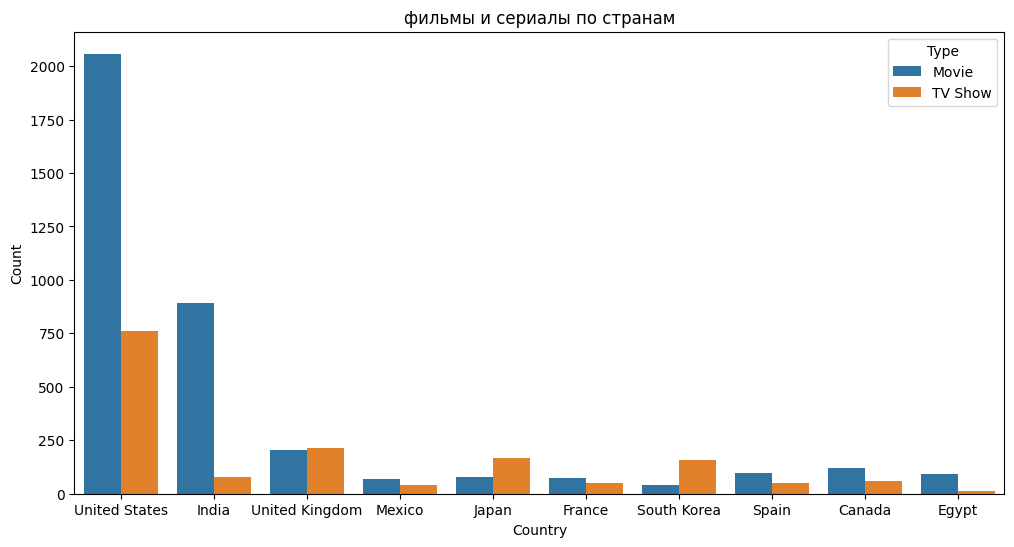

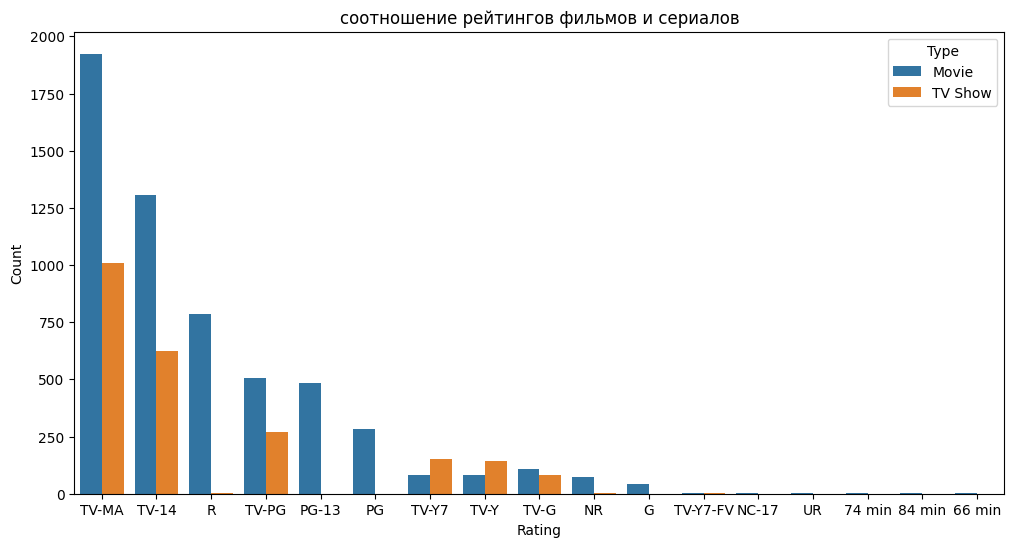

<ipython-input-2-0c9719f18c9d>:28: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['type'] == 'Movie']['release_year'], label='Movies', shade=True)
<ipython-input-2-0c9719f18c9d>:29: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['type'] == 'TV Show']['release_year'], label='TV Shows', shade=True)


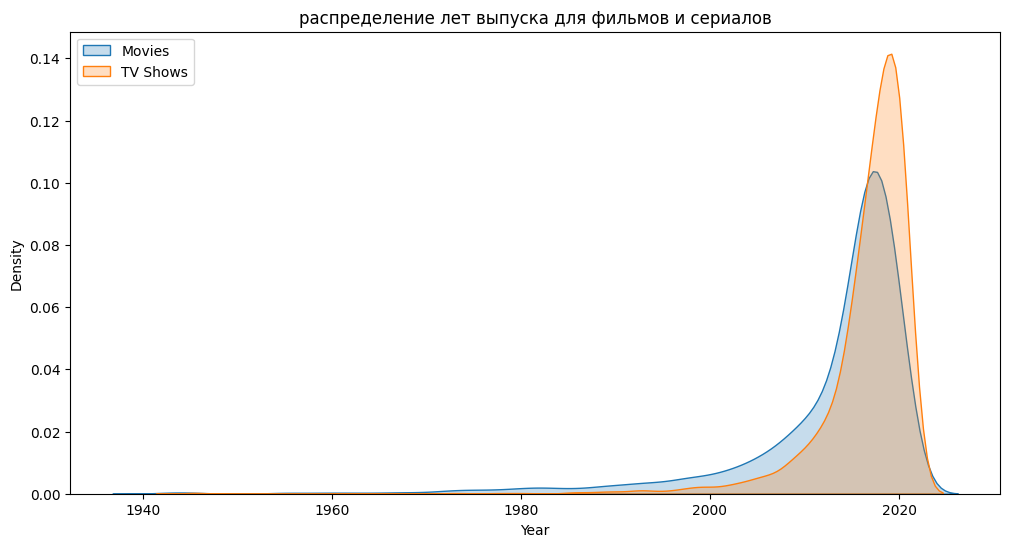

<ipython-input-2-0c9719f18c9d>:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='country')


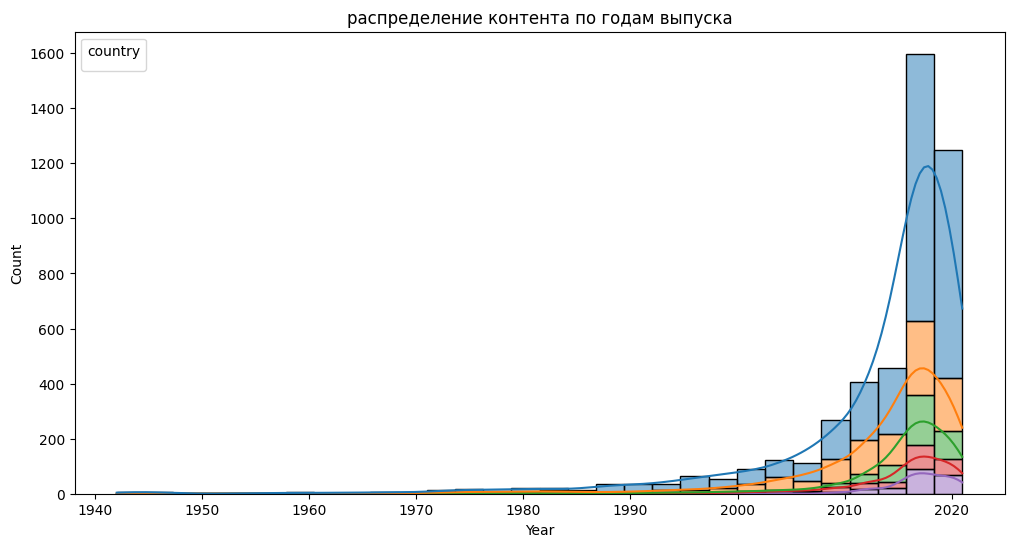

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

df = df.dropna(subset=['release_year', 'type', 'rating', 'country'])

# 1
plt.figure(figsize=(12, 6))
country_type_counts = pd.crosstab(df['country'], df['type'])
top_countries = country_type_counts.sum(axis=1).sort_values(ascending=False).head(10).index
sns.countplot(data=df[df['country'].isin(top_countries)], x='country', hue='type')
plt.title('фильмы и сериалы по странам')
plt.xlabel('Country')
plt.ylabel('Count')
plt.legend(title='Type')
plt.show()

# 2
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='rating', hue='type', order=df['rating'].value_counts().index)
plt.title('соотношение рейтингов фильмов и сериалов')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.legend(title='Type')
plt.show()

# 3
plt.figure(figsize=(12, 6))
sns.kdeplot(df[df['type'] == 'Movie']['release_year'], label='Movies', shade=True)
sns.kdeplot(df[df['type'] == 'TV Show']['release_year'], label='TV Shows', shade=True)
plt.title('распределение лет выпуска для фильмов и сериалов')
plt.xlabel('Year')
plt.ylabel('Density')
plt.legend()
plt.show()

# 4
plt.figure(figsize=(12, 6))
top_5_countries = df['country'].value_counts().head(5).index
sns.histplot(data=df[df['country'].isin(top_5_countries)], x='release_year', hue='country', kde=True, bins=30, multiple='stack')
plt.title('распределение контента по годам выпуска')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='country')
plt.show()


Сформируем двухвыборочные гипотезы касательно медиан и распределений для дискретного и непрерывного случая. Если дискретного показателя нет - создаем его дополнительно. Итого 4 гипотезы (4 пункта)

Гипотеза 1:
Медиана количества выпущенных фильмов во Франции и в Мексике одинакова.
$$ H_0: \text{median}(\text{count, France}) = \text{median}(\text{count, TV Mexico}) $$

Гипотеза 2:
Медианы лет выпуска контента, выпущенного в Индии и Великобритании, равны.
$$ H_0: \text{median}(\text{release_year, India}) = \text{median}(\text{release_year, UK}) $$

Гипотеза 3:
Распределение рейтингов одинаково для фильмов с рейтингами TV-Y vs TV-Y7

Гипотеза 4:
Распределение категорий контента (Movies и TV Shows) одинаково для США и Индии.

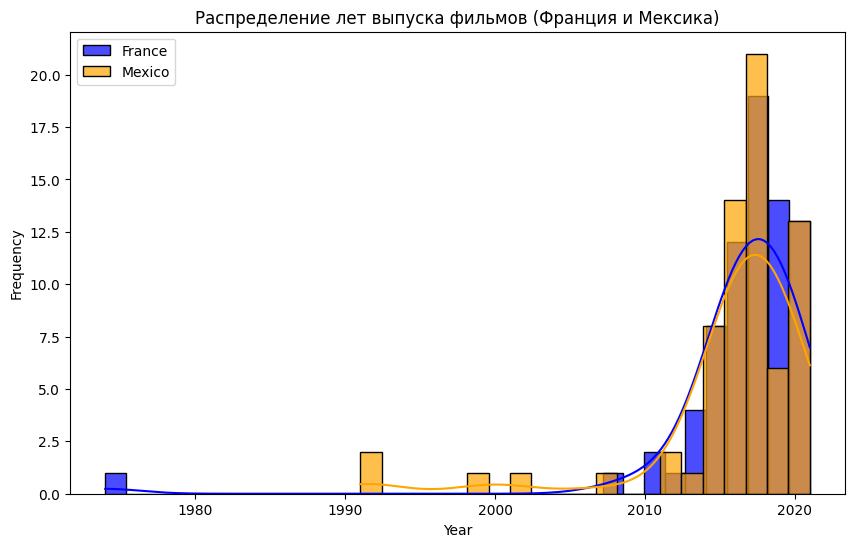

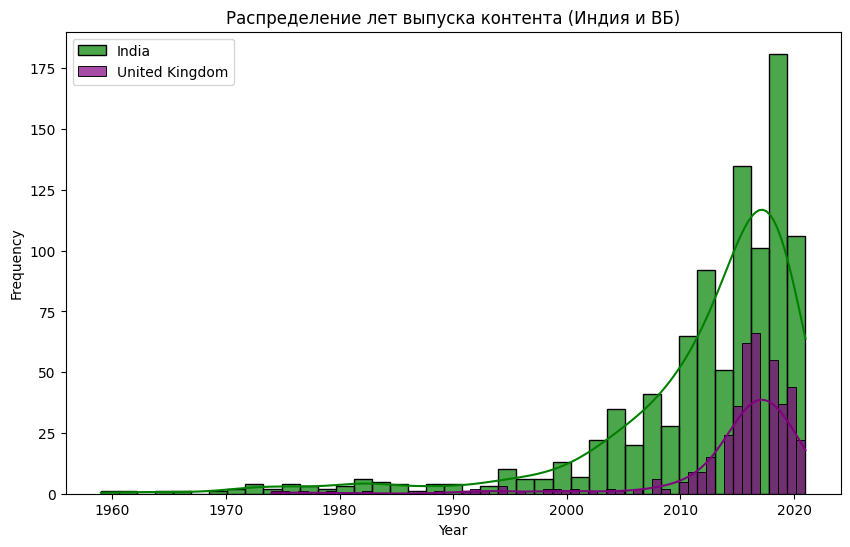

<Figure size 1000x600 with 0 Axes>

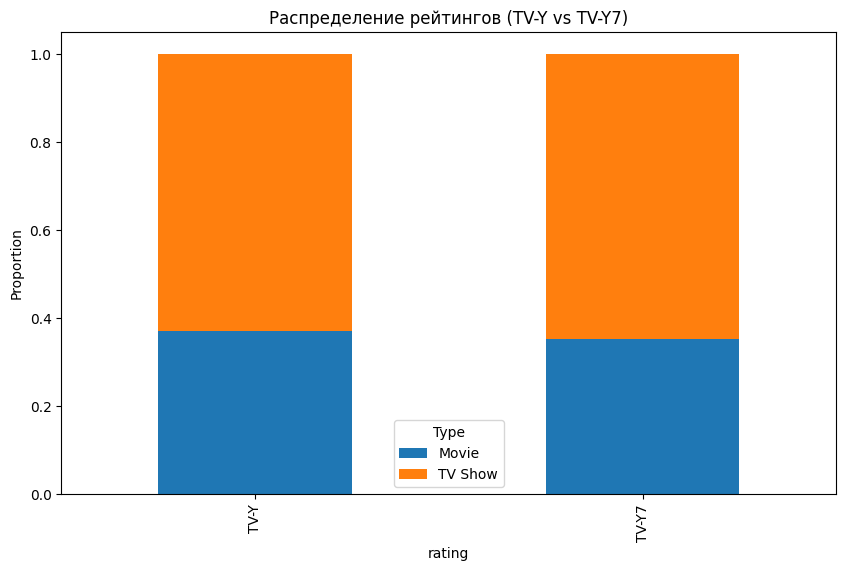

<Figure size 800x600 with 0 Axes>

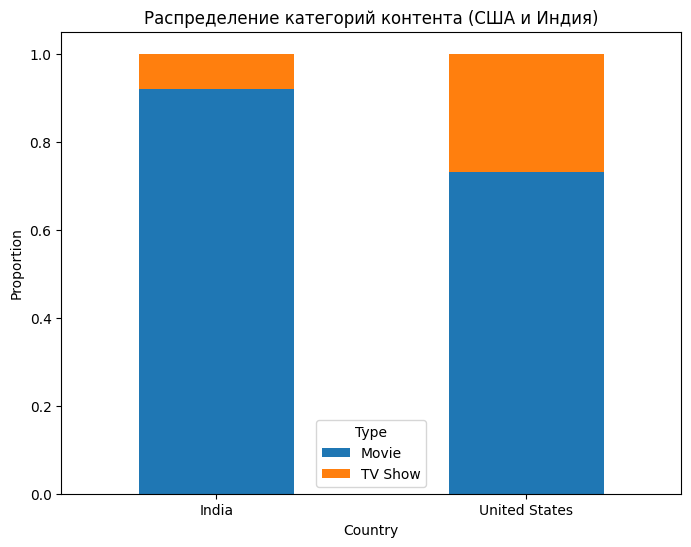

                                         Гипотеза     Статистика       p-value
0       Медиана кол-ва фильмов (France vs Mexico)    2786.500000  5.206325e-01
1               Медианы лет выпуска (India vs UK)  156504.000000  6.089741e-12
2        Распределение рейтингов (TV-PG vs PG-13)       0.098740  7.533470e-01
3  Распределение категорий контента (US vs Spain)     147.764462  5.340953e-34
Гипотеза 1 НЕ отвергается (p-value=0.521)
Гипотеза 3 НЕ отвергается (p-value=0.753)


In [3]:
# 1
movies_france = df[(df['type'] == 'Movie') & (df['country'] == 'France')]
movies_mexico = df[(df['type'] == 'Movie') & (df['country'] == 'Mexico')]

stat1, pval1 = mannwhitneyu(movies_france['release_year'], movies_mexico['release_year'], alternative='two-sided')

plt.figure(figsize=(10, 6))
sns.histplot(movies_france['release_year'], label='France', kde=True, color='blue', alpha=0.7)
sns.histplot(movies_mexico['release_year'], label='Mexico', kde=True, color='orange', alpha=0.7)
plt.title('Распределение лет выпуска фильмов (Франция и Мексика)')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 2
india_content = df[df['country'] == 'India']['release_year']
uk_content = df[df['country'] == 'United Kingdom']['release_year']

stat2, pval2 = mannwhitneyu(india_content, uk_content, alternative='two-sided')
plt.figure(figsize=(10, 6))
sns.histplot(india_content, label='India', kde=True, color='green', alpha=0.7)
sns.histplot(uk_content, label='United Kingdom', kde=True, color='purple', alpha=0.7)
plt.title('Распределение лет выпуска контента (Индия и ВБ)')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 3
rating_tv_y = df[df['rating'] == 'TV-Y']
rating_tv_y7 = df[df['rating'] == 'TV-Y7']

rating_contingency = pd.crosstab(
    df[df['rating'].isin(['TV-Y', 'TV-Y7'])]['rating'],
    df[df['rating'].isin(['TV-Y', 'TV-Y7'])]['type']
)
chi2_stat3, pval3, _, _ = chi2_contingency(rating_contingency)

plt.figure(figsize=(10, 6))
rating_tv_y_y7_counts = rating_contingency.div(rating_contingency.sum(axis=1), axis=0)
rating_tv_y_y7_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Распределение рейтингов (TV-Y vs TV-Y7)')
plt.ylabel('Proportion')
plt.legend(title='Type')
plt.show()

# 4
filtered_df = df[df['country'].isin(['United States', 'India'])]
country_contingency = pd.crosstab(filtered_df['country'], filtered_df['type'])

chi2_stat4, pval4, _, _ = chi2_contingency(country_contingency)

plt.figure(figsize=(8, 6))
country_content_counts = country_contingency.div(country_contingency.sum(axis=1), axis=0)
country_content_counts.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title('Распределение категорий контента (США и Индия)')
plt.ylabel('Proportion')
plt.xlabel('Country')
plt.legend(title='Type')
plt.xticks(rotation=0)
plt.show()

# итог
results = pd.DataFrame({
    'Гипотеза': [
        'Медиана кол-ва фильмов (France vs Mexico)',
        'Медианы лет выпуска (India vs UK)',
        'Распределение рейтингов (TV-PG vs PG-13)',
        'Распределение категорий контента (US vs Spain)'
    ],
    'Статистика': [stat1, stat2, chi2_stat3, chi2_stat4],
    'p-value': [pval1, pval2, pval3, pval4]
})

print(results)
for i, row in results.iterrows():
    if row['p-value'] > 0.05:
        print(f"Гипотеза {i+1} НЕ отвергается (p-value={row['p-value']:.3f})")


Видим, что не отвергаем 1 и 3 нулевые гипотезы, остальные имеют крайне низкий p-value, так что имеем основания, чтобы их отвергнуть

Для проверки 1 и 2 гипотез я использовала тест Уилкоксона-Манна-Уитни, так как он подходит для количественных данных, когда мы хотим сравнить медианы. Также наши данные в обоих случаях могут быть не нормально распределены, что подходит для этого теста.

Для гипотез 3-4 я использовала тест Пирсона (хи-квадрат), так как он как раз подходит для сравнения распределений двух групп по нескольким категориям (а нам как раз даны категории), также наши данные имеют достаточно большую выборку (тест будет корректно работать)

In [4]:
# медианы
def bootstrap_median_diff(data1, data2, n_bootstrap=10000):
    diff_bootstrap = []
    for _ in range(n_bootstrap):
        sample1 = np.random.choice(data1, size=len(data1), replace=True)
        sample2 = np.random.choice(data2, size=len(data2), replace=True)
        diff_bootstrap.append(np.median(sample1) - np.median(sample2))
    return diff_bootstrap

# 1
movies_france_years = movies_france['release_year'].values
movies_mexico_years = movies_mexico['release_year'].values

bootstrap_diff_1 = bootstrap_median_diff(movies_france_years, movies_mexico_years)
ci_1 = np.percentile(bootstrap_diff_1, [5, 95])
pval_bootstrap_1 = np.mean(np.array(bootstrap_diff_1) > 0)

print(f"Гипотеза 1 (France vs Mexico):")
print(f"Доверительный интервал: {ci_1}")
print(f"p-value (бутстрап): {pval_bootstrap_1:.3f}")

# 2
india_years = india_content.values
uk_years = uk_content.values

bootstrap_diff_2 = bootstrap_median_diff(india_years, uk_years)
ci_2 = np.percentile(bootstrap_diff_2, [5, 95])
pval_bootstrap_2 = np.mean(np.array(bootstrap_diff_2) > 0)

print(f"Гипотеза 2 (India vs UK):")
print(f"Доверительный интервал: {ci_2}")
print(f"p-value (бутстрап): {pval_bootstrap_2:.3f}")

# распределения
def bootstrap_proportion_diff(data1, data2, n_bootstrap=10000):
    diff_bootstrap = []
    for _ in range(n_bootstrap):
        sample1 = np.random.choice(data1, size=len(data1), replace=True)
        sample2 = np.random.choice(data2, size=len(data2), replace=True)
        prop1 = np.mean(sample1 == 'Movie')
        prop2 = np.mean(sample2 == 'Movie')
        diff_bootstrap.append(prop1 - prop2)
    return diff_bootstrap

# 3
tv_y_types = rating_tv_y['type'].values
tv_y7_types = rating_tv_y7['type'].values

bootstrap_diff_3 = bootstrap_proportion_diff(tv_y_types, tv_y7_types)
ci_3 = np.percentile(bootstrap_diff_3, [5, 95])
pval_bootstrap_3 = np.mean(np.array(bootstrap_diff_3) > 0)

print(f"Гипотеза 3 (TV-Y vs TV-Y7):")
print(f"Доверительный интервал: {ci_3}")
print(f"p-value: {pval_bootstrap_3:.3f}")

# 4
us_types = filtered_df[filtered_df['country'] == 'United States']['type'].values
india_types = filtered_df[filtered_df['country'] == 'India']['type'].values

bootstrap_diff_4 = bootstrap_proportion_diff(us_types, india_types)
ci_4 = np.percentile(bootstrap_diff_4, [5, 95])
pval_bootstrap_4 = np.mean(np.array(bootstrap_diff_4) > 0)

print(f"Гипотеза 4 (US vs India):")
print(f"Доверительный интервал: {ci_4}")
print(f"p-value: {pval_bootstrap_4:.3f}")

Гипотеза 1 (France vs Mexico):
Доверительный интервал: [-1.  1.]
p-value (бутстрап): 0.357
Гипотеза 2 (India vs UK):
Доверительный интервал: [-2. -1.]
p-value (бутстрап): 0.000
Гипотеза 3 (TV-Y vs TV-Y7):
Доверительный интервал: [-0.05536474  0.09105503]
p-value: 0.664
Гипотеза 4 (US vs India):
Доверительный интервал: [-0.20825721 -0.16822777]
p-value: 0.000


Видно, что результаты тестов и бутстрапа согласованы, но бутстрап дает более грубые результаты. Тесты (в данном случае Уилкоксона-Манна-Уитни и Пирсона) мощнее при больших выборках и при соблюдении предположений для них (что в нашем случае выполняется), но они не дают информации о размере эффекта (разнице медиан например). Зато бутстрап предоставляет такую информацию (доверительные интервалы), но нужно учитывать, что у нас не супер большие выборки, поэтому бутстрап менее точен. Я бы использовала бутстрап как дополнительный инструмент для перепроверки своих выводов.